# Context overview

This implementaion is credit to this [Notebook](https://www.kaggle.com/code/lextoumbourou/feedback3-eda-hf-custom-trainer-sift)
Here we present the ELLIPSE corpus, a dataset consisting of argumentative essays submitted by students in grades 8 through 12. (ELLs). The essays have been graded on the basis of six criteria: coherence, syntax, vocabulary, phraseology, grammar, and conventions.

Using a scale from 1.0 (very poor) to 5.0 (very good), in increments of 0.5, each measure represents a different aspect of writing competence. The goal here is to estimate how each metric will be scored for the test set's essay examples.

## Let's dive in

The predictive power of the count features, such as total words, unique words, and whitespace, will be investigated first. The usage of unsupervised topic grouping categories could be helpful for tests of conventions or grammar. Initially, we will focus on LDA. It's possible that specific phrases have some predictive power, but these effects are so small that they're obscured by the noise. Glove and Huggingface are examples of word embeddings that could more accurately portray meaning. However, I'm sceptical that the choice of essay topic has a significant impact on any of the six ELL metrics.

Even though the number of essays is quite low for a deep learning run, I can't resist the urge to dive into CNN or LSTM deep learning predictive models. I spent some time working with the torch approach on tidymodels, but I soon realised that the amount of modelling time it required was enormous, and the results were not any more accurate than those obtained with random forests. In the end, I decided to go with the lightgbm strategy for this. It is extremely accurate with regard to certain word and text counts, such as the total number of distinct words.


In [1]:
#importing the dependencies
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from collections import defaultdict
from IPython.core.display import display, HTML

from sklearn.feature_extraction.text import CountVectorizer

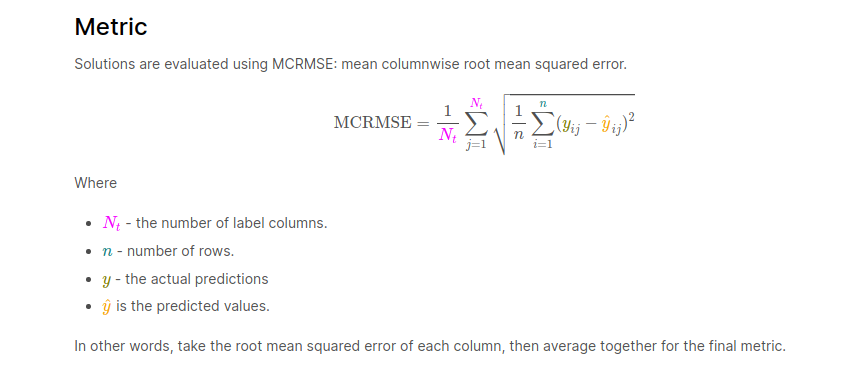

In [2]:
def mcrmse(targets, predictions):
    error = targets - predictions
    squared_error = np.square(error)
    colwise_mse = np.mean(squared_error, axis=0)
    root_colwise_mse = np.sqrt(colwise_mse)
    return np.mean(root_colwise_mse, axis=0)

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/Kaggle Compettions/Feedback Prize - English Language Learning/dataset/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Kaggle Compettions/Feedback Prize - English Language Learning/dataset/test.csv')

In [4]:
df_train.head(2)
#df_test.tail(2)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5


In [5]:
df_train.columns, len(df_train)

(Index(['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary',
        'phraseology', 'grammar', 'conventions'],
       dtype='object'), 3911)

In [6]:
df_test.columns, len(df_test)

(Index(['text_id', 'full_text'], dtype='object'), 3)

In [7]:
df_test

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [8]:
df_train['full_text'].iloc[1] # grab the full text of the next student

"When a problem is a change you have to let it do the best on you no matter what is happening it can change your mind. sometimes you need to wake up and look what is around you because problems are the best way to change what you want to change along time ago. A\n\nproblem is a change for you because it can make you see different and help you to understand how tings wok.\n\nFirst of all it can make you see different then the others. For example i remember that when i came to the United States i think that nothing was going to change me because i think that nothing was going to change me because everything was different that my country and then i realist that wrong because a problem may change you but sometimes can not change the way it is, but i remember that i was really shy but i think that change a lot because sometimes my problems make me think that there is more thing that i never see in my life but i just need to see it from a different way and dont let nothing happened and ruing

In [9]:
# number of labels on the trainig dataset
labels = ['cohesion', 'syntax', 'vocabulary',
        'phraseology', 'grammar', 'conventions']

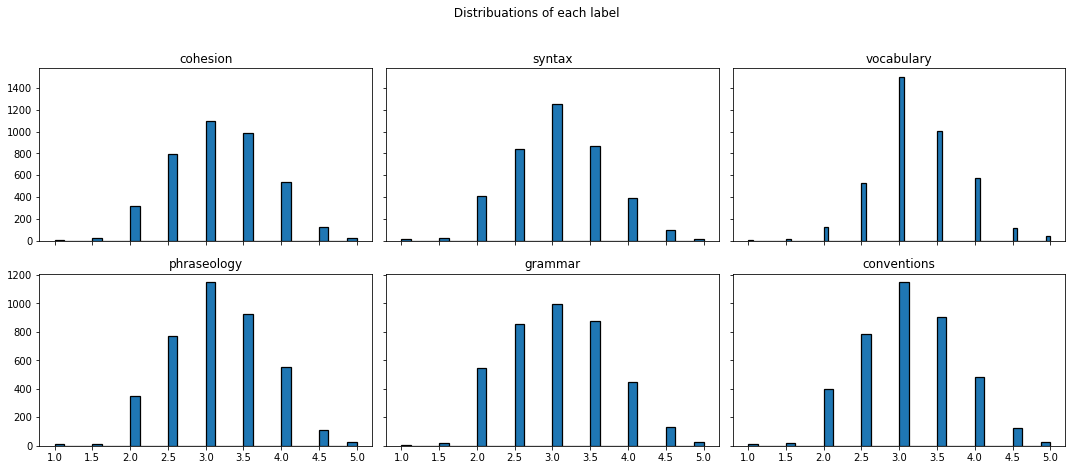

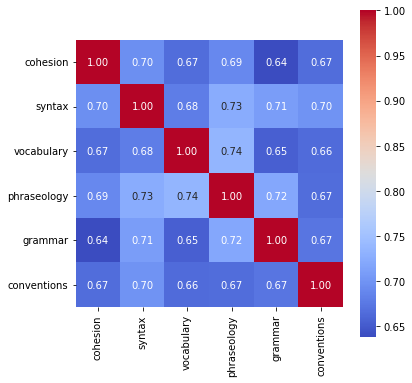

In [10]:
# plot the distirbuaitons and the correlation of each these labels
fig, axes = plt.subplots(2, len(labels)//2,sharex='col', sharey='row', figsize=(15, 6))
fig.suptitle(' Distribuations of each label ', y = 1.08)

for i, label in enumerate(labels):
    ax = axes.flat[i]
    sns.histplot(x=label, data=df_train, linewidth=1.25, alpha=1, ax=ax, zorder=2)
    ax.set_title(label)
    ax.set(xlabel=None, ylabel=None)
    
plt.tight_layout()
plt.show()

corr = df_train[labels].corr()
fig, ax = plt.subplots(figsize=(6,6))        
#sns.heatmap(corr, cmap = "RdBu", square=True, annot=True, ax=ax)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, square=True, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

## Visualize the kth text (k \# of caracters) using helper functions

In [11]:
def text_samples(df, k):
    
    inner_html = ""
    for idx, row in df.iterrows():
        #f'assert {k <= len(df[idx])} , {k} must be less than the length of the input text'
        inner_html += f"""
        <td style="vertical-align:top; border-right: 1px solid #7accd8">
        <h3 style="text-align:left">{row.text_id}</h3>
        <hr>
            <dl>
                <dt>Cohesion</dt>
                <dd>{row.cohesion}</dd>
                
                <dt>Syntax</dt>
                <dd>{row.syntax}</dd>
                
                <dt>Vocabulary</dt>
                <dd>{row.vocabulary}</dd>
                
                <dt>Phraseology</dt>
                <dd>{row.phraseology}</dd>
                
                <dt>Grammar</dt>
                <dd>{row.grammar}</dd>
                
                <dt>Conventions</dt>
                <dd>{row.conventions}</dd>
            </dl>
            
            <hr>
            <p>
            {row.full_text[:k]}
            </p>
        </td>
        """

    display(HTML(f"""
    <table style="font-family: monospace;">
        <tr>
             {inner_html}
        </tr>
    </table>
    """))

In [12]:
# pick a random text 
texts = df_train.sample(frac=1, random_state=150).head(4)
text_samples(texts, 100)

738112C600B8 Cohesion 3.0 Syntax 3.5 Vocabulary 4.0 Phraseology 3.5 Grammar 3.5 Conventions 3.0 Do you think first impressions are impossible to change ? In my opinion a first impression on someon,"B312F104B015 Cohesion 4.0 Syntax 3.5 Vocabulary 4.0 Phraseology 3.5 Grammar 3.5 Conventions 4.0 I agree that the option the some schools are offering is very beneficial for students, which is the",A2957D006D28 Cohesion 4.5 Syntax 4.0 Vocabulary 4.0 Phraseology 4.0 Grammar 4.0 Conventions 4.0 It has been said that the first impression are almost impossible to change. I disagree because when,"F5817C081342 Cohesion 3.5 Syntax 3.5 Vocabulary 4.0 Phraseology 4.0 Grammar 3.0 Conventions 3.5 Is a positive attitude key to success? Well, In my opinion I strongly agree, I believe a positive at"


In [13]:
# normalize the text by convering the captitals to smallers latter
df_train['total_score'] = df_train[labels].sum(axis=1)
lowest_df = df_train.sort_values('total_score').head(4)

text_samples(lowest_df, 100)

767533E12569 Cohesion 1.0 Syntax 1.0 Vocabulary 1.0 Phraseology 1.0 Grammar 1.0 Conventions 1.0 he is a good because they are the prescient and us. now the are more procession a other prescient an,48EA282A4EAF Cohesion 1.0 Syntax 1.0 Vocabulary 1.0 Phraseology 1.0 Grammar 1.0 Conventions 1.0 some student offer distance learning as an option for student to attend classes from homr by wat of,"DB2EA5C4828F Cohesion 1.0 Syntax 1.0 Vocabulary 1.5 Phraseology 1.0 Grammar 1.0 Conventions 1.0 Technology is positive, because is the good possibility for people the accomplish method system, the",F69C85F4C3CA Cohesion 1.0 Syntax 1.0 Vocabulary 1.5 Phraseology 1.0 Grammar 1.0 Conventions 1.5 the memorable teacher ever had was a teacher in 10 word wild all students


In [14]:
# get the highest scoring samples
df_train['total_score'] = df_train[labels].sum(axis=1)
highest = df_train.sort_values('total_score', ascending=False).head(2)
text_samples(highest, 100)

B1AFACE6704E Cohesion 5.0 Syntax 5.0 Vocabulary 5.0 Phraseology 5.0 Grammar 5.0 Conventions 5.0 I agree with Michelangelo's statement as I have found through experience that it benefits me more to,52DC3B7C3952 Cohesion 5.0 Syntax 5.0 Vocabulary 4.5 Phraseology 5.0 Grammar 5.0 Conventions 5.0 Working From Home Should students be allowed to attend classes from home? I agree that attending cl


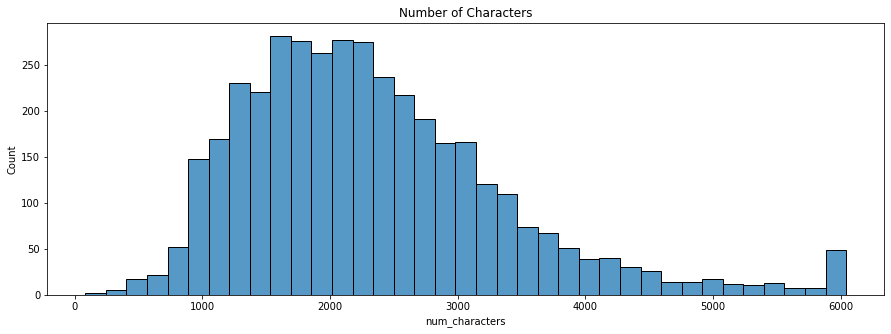

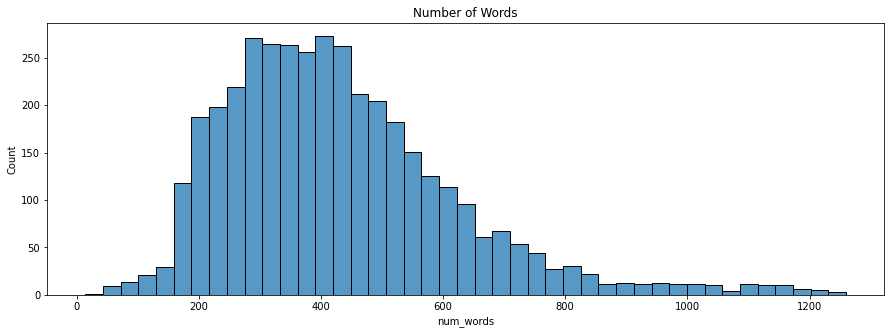

In [15]:
# Histogram number of characters and words
fig = plt.figure(figsize=(15, 5))
df_train['num_characters'] = df_train['full_text'].str.len()
sns.histplot(data=df_train, x="num_characters")
plt.title("Number of Characters")
plt.show()

fig = px.histogram(df_train, x = df_train['full_text'].str.len(), marginal="box", 
                   title = "Number of Characters", color_discrete_sequence=["#FFA200"])
fig.update_layout(bargap=0.2)
fig.update_layout(template="plotly_dark", font=dict(family="PT Sans", size=18, color="#C4FEFF"))
fig.show()

fig = plt.figure(figsize=(15, 5))
df_train['num_words'] = df_train['full_text'].apply(lambda x: len(x.split()))
sns.histplot(data=df_train, x="num_words")
plt.title("Number of Words")
plt.show()

fig = px.histogram(df_train, x = df_train['num_words'], marginal="box", 
                   title = "Number of Words", color_discrete_sequence=["#FFA200"])
fig.update_layout(bargap=0.2)
fig.update_layout(template="plotly_dark", font=dict(family="PT Sans", size=18, color="#C4FEFF"))
fig.show()

In [16]:
# word frequencies
df_train['num_words'].describe()

count    3911.000000
mean      430.492969
std       191.868449
min        14.000000
25%       294.000000
50%       402.000000
75%       526.500000
max      1260.000000
Name: num_words, dtype: float64

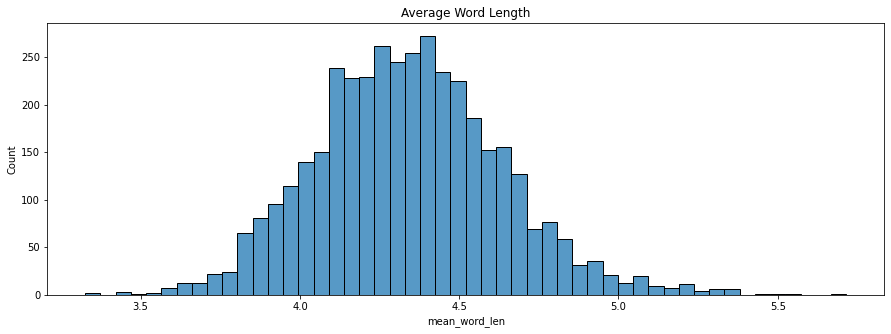

In [17]:
# Average Word Length¶
fig = plt.figure(figsize=(15, 5))
df_train['mean_word_len'] = df_train['full_text'].str.split().apply(lambda x : np.mean([len(i) for i in x]))
sns.histplot(data=df_train, x="mean_word_len")
plt.title("Average Word Length")
plt.show()

In [18]:
# average word's length 
fig = px.histogram(df_train, x=df_train['mean_word_len'], marginal="box", 
                   title = "Average Word Length", color_discrete_sequence=["#FFA200"])
fig.update_layout(bargap=0.2)
fig.update_layout(template="plotly_dark", font=dict(family="PT Sans", size=18, color="#C4FEFF"))
fig.show()

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

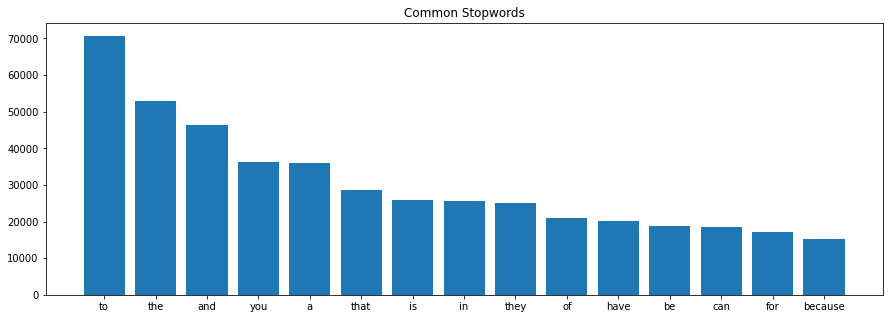

In [20]:
# extract the sopt workds
fig = plt.figure(figsize=(15, 5))

stop_words = set(stopwords.words('english'))
corpus = ''.join(df_train.full_text).split()

dic = defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word] += 1
top_words = sorted(dic.items(), key=lambda x:x[1], reverse=True)[:15] 
x, y = zip(*top_words)
plt.bar(x, y)
plt.title('Common Stopwords')
plt.show()

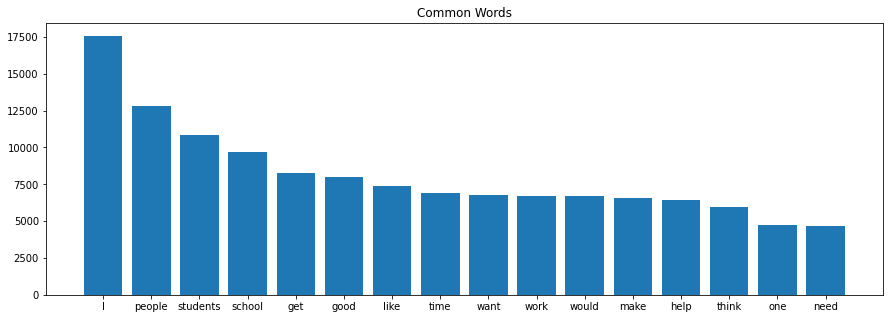

In [21]:
# common words 

fig = plt.figure(figsize=(15, 5))

counter = Counter(corpus)
words = counter.most_common()

x, y = [], []
i = 0
for word, count in words:
    if (word not in stop_words):
        x.append(word)
        y.append(count)  
        i += 1
    if i > 15:
        break
plt.bar(x, y)
plt.title('Common Words')
plt.show()


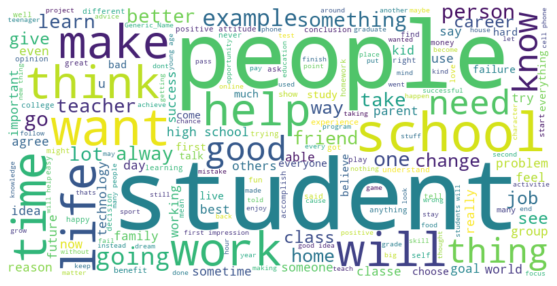

In [22]:
# plot word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(df_train.full_text))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

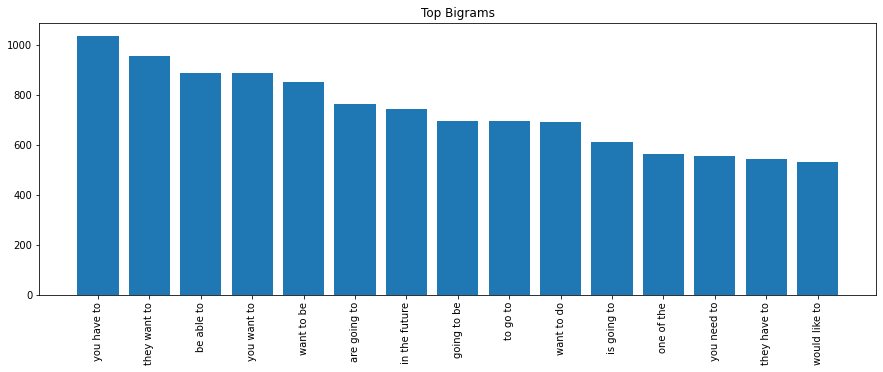

In [23]:
# N-gram analysis
fig = plt.figure(figsize=(15, 5))

def get_top_bigrams(corpus, n):
    vectorizer = CountVectorizer(ngram_range=(n,n)).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq

top_bigrams = get_top_bigrams(df_train['full_text'], n=3)[:15]
x, y = map(list, zip(*top_bigrams))
plt.bar(x, y)
plt.title('Top Bigrams')
plt.xticks(rotation=90)
plt.show()

In [24]:
#!pip install transformers[sentencepiece]
#!pip install datasets

In [25]:
import logging
from types import SimpleNamespace
from pathlib import Path
from dataclasses import dataclass
from typing import Union, Optional
from torch import nn
import torch
from torch.nn import MSELoss

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.core.display import display, HTML
import seaborn as sns
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from transformers.data.data_collator import DataCollatorMixin
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.utils import PaddingStrategy
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig, AutoModel
from transformers.modeling_outputs import TokenClassifierOutput
from transformers import DataCollatorWithPadding
from wordcloud import WordCloud

# From this Gist: https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [26]:
config = SimpleNamespace()

config.seed = 420
config.model_name = 'microsoft/deberta-v3-large'
config.output_path = Path('./')
config.input_path = Path('../input/feedback-prize-english-language-learning')
config.tmp_path = Path('/kaggle/temp/')

config.n_folds = 4

config.epochs = 3

config.max_len = 512

config.eval_per_epoch = 2
config.replace_newline = '[BR]'
config.add_prefix_space = False
config.folds_to_train = {0,1,2,3}

config.bilstm_layer = False

config.batch_size = 4
config.gradient_accumulation_steps = 4
config.group_by_length = True
config.gradient_checkpointing = True

config.lr = 1e-5
config.backbone_lr_fraction = 1

config.warm_up_ratio = 0.
config.weight_decay = 0.01

config.hidden_dropout_prob = 0.
config.token_dropout_prob = 0.
config.attention_probs_dropout_prob = 0

config.start_adv_training_on_epoch = 1

logging.disable(logging.WARNING)

seed_everything(config.seed)

In [27]:
config.tmp_path.mkdir(exist_ok=True, parents=True)


In [28]:
# setup the CV using multi-label startified fold 
kfolds = MultilabelStratifiedKFold(n_splits=config.n_folds, shuffle=True, random_state=420)

df_train['fold'] = -1
for fold_num, (train_idxs, test_idxs) in enumerate(kfolds.split(df_train.index, df_train[labels].values)):
    df_train.loc[test_idxs, ['fold']] = fold_num

In [29]:
df_train.fold.value_counts()

0    978
3    978
1    978
2    977
Name: fold, dtype: int64

In [30]:
df_train.to_csv(config.output_path / 'train_folds.csv', index=False)


# Data Prep and Tokenisation¶
Deberta-v2 and v3 models strips \n characters. In the last 2 competitions, it was a useful feature for the model to differentiate between discourse sections, so it can be useful to replace with a special character.

In [31]:
def maybe_replace_newline(text):
    if config.replace_newline:
        text = text.replace('\n', config.replace_newline)

    return text

In [32]:
all_special_tokens = []
if config.replace_newline:
    all_special_tokens.append(config.replace_newline)

tokenizer = AutoTokenizer.from_pretrained(config.model_name, use_fast=True, add_prefix_space=config.add_prefix_space, additional_special_tokens=all_special_tokens, return_special_tokens_mask=True)
tokenizer.model_max_length = config.max_len

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:447: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.



In [33]:
tokenizer

PreTrainedTokenizerFast(name_or_path='microsoft/deberta-v3-large', vocab_size=128000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]', 'additional_special_tokens': ['[BR]']})

function that the HuggingFace dataset uses to tokenise and numerices the dataset by including a length attribute to allow for sorting the dataset by length, which significantly speeds up training and inference tim

In [34]:
def tokenizer_func(x):
    output = tokenizer([maybe_replace_newline(t) for t in x["full_text"]], truncation=True)
    output['length'] = [len(a) for a in output['input_ids']]
    return output

In [35]:
# grap an example
tok = tokenizer_func({'full_text': [df_train.iloc[100].full_text[:200]]})
tok

{'input_ids': [[1, 8211, 84435, 269, 423, 401, 262, 738, 269, 298, 262, 872, 576, 267, 18078, 690, 261, 304, 355, 799, 361, 264, 282, 14098, 261, 1744, 261, 263, 9939, 264, 690, 291, 295, 282, 266, 431, 397, 3086, 1492, 2]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'length': [40]}

In [36]:
# reverse the above tokenized one
tokenizer.decode(tok['input_ids'][0])

'[CLS] Albert Schweitzer is right because the example is not the main thing in influencing others, but people learn how to be respectful, responsible, and thoughtful to others this can be a really good examp[SEP]'

# set a 5% token dropout  probability  for trainining


In [37]:
@dataclass
class DataCollatorWithTokenDropout(DataCollatorMixin):
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    return_tensors: str = "pt"
    dropout_prob: float = 0.5

    def torch_call(self, features):
        batch = self.tokenizer.pad(
            features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )

        # If special token mask has been preprocessed, pop it from the dict.
        special_tokens_mask = batch.pop("special_tokens_mask", None)
        if self.dropout_prob > 0:
            batch["input_ids"] = self.torch_mask_tokens(
                batch["input_ids"], special_tokens_mask=special_tokens_mask
            )

        if "label" in batch:
            batch["labels"] = batch["label"]
            del batch["label"]
        if "label_ids" in batch:
            batch["labels"] = batch["label_ids"]
            del batch["label_ids"]

        return batch

    def torch_mask_tokens(self, inputs, special_tokens_mask = None):
        import torch

        probability_matrix = torch.full(inputs.shape, self.dropout_prob)
        if special_tokens_mask is None:
            special_tokens_mask = [
                self.tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in inputs.clone().tolist()
            ]
            special_tokens_mask = torch.tensor(special_tokens_mask, dtype=torch.bool)
        else:
            special_tokens_mask = special_tokens_mask.bool()

        probability_matrix.masked_fill_(special_tokens_mask, value=0.0)
        masked_indices = torch.bernoulli(probability_matrix).bool()\

        # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
        indices_replaced = torch.bernoulli(torch.full(inputs.shape, 0.8)).bool() & masked_indices
        inputs[indices_replaced] = self.tokenizer.convert_tokens_to_ids(self.tokenizer.mask_token)

        # 10% of the time, we replace masked input tokens with random word
        indices_random = torch.bernoulli(torch.full(inputs.shape, 0.5)).bool() & masked_indices & ~indices_replaced
        random_words = torch.randint(len(self.tokenizer), inputs.shape, dtype=torch.long)
        inputs[indices_random] = random_words[indices_random]

        # The rest of the time (10% of the time) we keep the masked input tokens unchanged
        return inputs

# Mean, Min and Max Pooling Implementations
Training  using both three choices to opt the optimal one

In [38]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class MaxPooling(nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim=1)
        return max_embeddings

class MinPooling(nn.Module):
    def __init__(self):
        super(MinPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = 1e4
        min_embeddings, _ = torch.min(embeddings, dim=1)
        return min_embeddings

# SiFT
Below is an implementation of SiFT, an Adversarial Training method for fine-tuning describes in the DeBERTa: Decoding-enhanced BERT with Disentangled Attention paper.

In [39]:
# Copyright (c) Microsoft, Inc. 2020
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.
#
# Author: penhe@microsoft.com
# Date: 01/25/2021
#

import torch
import torch.nn.functional as F

__all__ = ['PerturbationLayer', 'AdversarialLearner', 'hook_sift_layer']

class PerturbationLayer(torch.nn.Module):
  def __init__(self, hidden_size, learning_rate=1e-4, init_perturbation=1e-2):
    super().__init__()
    self.learning_rate = learning_rate
    self.init_perturbation = init_perturbation
    self.delta = None
    self.LayerNorm = torch.nn.LayerNorm(hidden_size, 1e-7, elementwise_affine=False)
    self.adversarial_mode = False

  def adversarial_(self, adversarial = True):
    self.adversarial_mode = adversarial
    if not adversarial:
      self.delta = None

  def forward(self, input):
    if not self.adversarial_mode:
      self.input = self.LayerNorm(input)
      return self.input
    else:
      if self.delta is None:
        self.update_delta(requires_grad=True)
      return self.perturbated_input

  def update_delta(self, requires_grad = False):
    if not self.adversarial_mode:
      return True
    if self.delta is None:
      delta = torch.clamp(self.input.new(self.input.size()).normal_(0, self.init_perturbation).float(), -2*self.init_perturbation, 2*self.init_perturbation)
    else:
      grad = self.delta.grad
      self.delta.grad = None
      delta = self.delta
      norm = grad.norm()
      if torch.isnan(norm) or torch.isinf(norm):
        return False
      eps = self.learning_rate
      with torch.no_grad():
        delta = delta + eps*grad/(1e-6 + grad.abs().max(-1, keepdim=True)[0])
    self.delta = delta.float().detach().requires_grad_(requires_grad)
    self.perturbated_input = (self.input.to(delta).detach() + self.delta).to(self.input)
    return True

def hook_sift_layer(model, hidden_size, learning_rate=1e-4, init_perturbation=1e-2, target_module = 'embeddings.LayerNorm'):
  """
  Hook the sift perturbation layer to and existing model. With this method, you can apply adversarial training
  without changing the existing model implementation.
  Params:
    `model`: The model instance to apply adversarial training
    `hidden_size`: The dimmension size of the perturbated embedding
    `learning_rate`: The learning rate to update the perturbation
    `init_perturbation`: The initial range of perturbation
    `target_module`: The module to apply perturbation. It can be the name of the sub-module of the model or the sub-module instance.
    The perturbation layer will be inserted before the sub-module.
  Outputs:
    The perturbation layers.
  """
  
  if isinstance(target_module, str):
    _modules = [k for n,k in model.named_modules() if  target_module in n]
    print(f'Will apply pertubations to layers: {_modules}')
  else:
    assert isinstance(target_module, torch.nn.Module), f'{type(target_module)} is not an instance of torch.nn.Module'
    _modules = [target_module]
  adv_modules = []
  for m in _modules:
    adv = PerturbationLayer(hidden_size, learning_rate, init_perturbation)
    def adv_hook(module, inputs):
      return adv(inputs[0])
    for h in list(m._forward_pre_hooks.keys()):
      if m._forward_pre_hooks[h].__name__ == 'adv_hook':
        del m._forward_pre_hooks[h]
    m.register_forward_pre_hook(adv_hook)
    adv_modules.append(adv)
  return adv_modules

class AdversarialLearner:
  """ Adversarial Learner
  This class is the helper class for adversarial training.
  Params:
    `model`: The model instance to apply adversarial training
    `perturbation_modules`: The sub modules in the model that will generate perturbations. If it's `None`,
    the constructor will detect sub-modules of type `PerturbationLayer` in the model.
  Example usage:
  ```python
  # Create DeBERTa model
  adv_modules = hook_sift_layer(model, hidden_size=768)
  adv = AdversarialLearner(model, adv_modules)
  def logits_fn(model, *wargs, **kwargs):
    logits,_ = model(*wargs, **kwargs)
    return logits
  logits,loss = model(**data)
  loss = loss + adv.loss(logits, logits_fn, **data)
  # Other steps is the same as general training.
  ```
  """
  def __init__(self, model, adv_modules=None):
    if adv_modules is None:
      self.adv_modules = [m for m in model.modules() if isinstance(m, PerturbationLayer)]
    else:
      self.adv_modules = adv_modules
    self.parameters = [p for p in model.parameters()]
    self.model = model

  def loss(self, target, logits_fn, loss_fn = 'symmetric-kl', *wargs, **kwargs):
    """
    Calculate the adversarial loss based on the given logits fucntion and loss function.
    Inputs:
    `target`: the logits from original inputs.
    `logits_fn`: the function that produces logits based on perturbated inputs. E.g.,
    ```python
    def logits_fn(model, *wargs, **kwargs):
      logits = model(*wargs, **kwargs)
      return logits
    ```
    `loss_fn`: the function that caclulate the loss from perturbated logits and target logits.
      - If it's a string, it can be pre-built loss functions, i.e. kl, symmetric_kl, mse.
      - If it's a function, it will be called to calculate the loss, the signature of the function will be,
      ```python
      def loss_fn(source_logits, target_logits):
        # Calculate the loss
        return loss
      ```
    `*wargs`: the positional arguments that will be passed to the model
    `**kwargs`: the key-word arguments that will be passed to the model
    Outputs:
      The loss based on pertubated inputs.
    """
    self.prepare()
    if isinstance(loss_fn, str):
      loss_fn = perturbation_loss_fns[loss_fn]
    pert_logits = logits_fn(self.model, *wargs, **kwargs)
    pert_loss = loss_fn(pert_logits, target.detach()).sum()
    pert_loss.backward()
    for m in self.adv_modules:
      ok = m.update_delta(True)

    for r,p in zip(self.prev, self.parameters):
      p.requires_grad_(r)
    pert_logits = logits_fn(self.model, *wargs, **kwargs)
    pert_loss = symmetric_kl(pert_logits, target)

    self.cleanup()
    return pert_loss.mean()

  def prepare(self):
    self.prev = [p.requires_grad for p in self.parameters]
    for p in self.parameters:
      p.requires_grad_(False)
    for m in self.adv_modules:
      m.adversarial_(True)
  
  def cleanup(self):
    for r,p in zip(self.prev, self.parameters):
      p.requires_grad_(r)

    for m in self.adv_modules:
      m.adversarial_(False)

def symmetric_kl(logits, target):
  logit_stu = logits.view(-1, logits.size(-1)).float()
  logit_tea = target.view(-1, target.size(-1)).float()
  logprob_stu = F.log_softmax(logit_stu, -1)
  logprob_tea = F.log_softmax(logit_tea, -1)
  prob_tea = logprob_tea.exp().detach()
  prob_stu = logprob_stu.exp().detach()
  floss = ((prob_tea*(-logprob_stu)).sum(-1))    # Cross Entropy
  bloss = ((prob_stu*(-logprob_tea)).sum(-1))    # Cross Entropy
  loss = floss + bloss
  return loss

def kl(logits, target):
  logit_stu = logits.view(-1, logits.size(-1)).float()
  logit_tea = target.view(-1, target.size(-1)).float()
  logprob_stu = F.log_softmax(logit_stu, -1)
  logprob_tea = F.log_softmax(logit_tea.detach(), -1)
  prob_tea = logprob_tea.exp()
  loss = ((prob_tea*(-logprob_stu)).sum(-1))    # Cross Entropy
  return loss

def mse(logits, target):
  logit_stu = logits.view(-1, logits.size(-1)).float()
  logit_tea = target.view(-1, target.size(-1)).float()
  return F.mse_loss(logit_stu.view(-1),logit_tea.view(-1))

perturbation_loss_fns = {
    'symmetric-kl': symmetric_kl,
    'kl': kl,
    'mse': mse
    }

In [49]:
# Cusoom model 
class CustomModel(nn.Module):
    def __init__(self, backbone):
        super(CustomModel, self).__init__()
        
        self.backbone = backbone

        self.config = self.backbone.config

        num_labels = len(labels)
        self.num_labels = num_labels

        self.mean_pooling = MeanPooling()
        # self.max_pooler = MaxPooling()
        # self.min_pooler = MinPooling()
        
        self.loss_func = MSELoss()
        
        if config.bilstm_layer:
            print('Including LSTM layer')
            self.lstm = nn.LSTM(
                self.config.hidden_size,
                (self.config.hidden_size) // 2,
                num_layers=2,
                dropout=self.config.hidden_dropout_prob,
                batch_first=True,
                bidirectional=True)

        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)
    
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        **kwargs
    ):
        outputs = self.backbone(
            input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        
        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)

        if config.bilstm_layer:
            output, hc = self.lstm(sequence_output)
        else:
            output = sequence_output

        mean_pool = self.mean_pooling(output, attention_mask)
        # max_pool = self.max_pooler(output, attention_mask)
        # min_pool = self.min_pooler(output, attention_mask)

        # concat = torch.cat([mean_pool], dim=1)
    
        logits = self.classifier(mean_pool)

        loss = None
        if labels is not None:
            logits = logits.view(-1, self.num_labels)
            loss = self.loss_func(logits, labels)

        output = (logits,) + outputs[1:]

        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

## Optimiser (diff lr for head and backbone)
The changes to the Trainer here are to support the following functionality:

Different learning rates for the backbone and head.
Different collators for train / eval / test (used to support token dropout).
Adversarial training, which starts on the 2nd epoch.

In [41]:
from torch.optim import AdamW

def get_optimizer_params(model, base_lr, weight_decay=0.0):
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    param_optimizer = list(model.named_parameters())

    print(f'Base lr: {base_lr}')
    backbone_lr = base_lr * config.backbone_lr_fraction
    print(f'Backbone lr: {backbone_lr}')
    optimizer_parameters = [
        {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)],
            'lr': backbone_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)],
            'lr': backbone_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "backbone" not in n],
            'lr': base_lr, 'weight_decay': 0.0}
    ]
    return optimizer_parameters

In [42]:
# Custom HuggingFace Trainer¶
class TrainerWithCustomOptim(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        adv_modules = hook_sift_layer(self.model, hidden_size=self.model.config.hidden_size)
        self.adv = AdversarialLearner(self.model, adv_modules)
        self._adv_started = False

    def create_optimizer(self):
        print('Creating custom optimiser.')
        kwargs = {
            "lr": self.args.learning_rate,
            "betas": (self.args.adam_beta1, self.args.adam_beta2),
            "eps": self.args.adam_epsilon,
        }
        self.optimizer = AdamW(get_optimizer_params(self.model, self.args.learning_rate, self.args.weight_decay), **kwargs)
        return self.optimizer

    def get_test_dataloader(self, test_dataset):
        print('Change collate for test')
        test_dataloader = super().get_test_dataloader(test_dataset)
        test_dataloader.collate_fn = DataCollatorWithPadding(tokenizer=self.data_collator.tokenizer, padding='longest')
        return test_dataloader
         
    def get_eval_dataloader(self, eval_dataset=None):
        print('Change collate for eval')
        eval_dataloader = super().get_eval_dataloader(eval_dataset)
        eval_dataloader.collate_fn = DataCollatorWithPadding(tokenizer=self.data_collator.tokenizer, padding='longest')
        return eval_dataloader
    
    def compute_loss(self, model, inputs, return_outputs=False):
        """Updated to add support for adversarial training."""
        outputs = model(**inputs)

        def logits_fn(model, *wargs, **kwargs):
            o = model(*wargs, **kwargs)
            return o.logits

        loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]

        if model.training and self.state.epoch >= config.start_adv_training_on_epoch:
            if not self._adv_started:
                self._adv_started = True
                print('Starting adversarial training')
    
            loss = loss + self.adv.loss(outputs.logits, logits_fn, loss_fn='mse', **inputs)

        return (loss, outputs) if return_outputs else loss

In [50]:
# Train
def compute_metrics(output):
    val_preds = np.clip(output.predictions, 1, 5)
    return {
        'rmse': mcrmse(output.label_ids, val_preds)
    }

def get_config():
    model_config = AutoConfig.from_pretrained(config.model_name, num_labels=len(labels))
    model_config.hidden_dropout_prob = config.hidden_dropout_prob
    model_config.attention_probs_dropout_prob = config.attention_probs_dropout_prob
    return model_config

def get_model():
    state_dict = AutoModel.from_pretrained(config.model_name).state_dict()

    model_config = get_config()
    backbone = AutoModel.from_config(model_config)
    backbone.load_state_dict(state_dict)

    if config.gradient_checkpointing:
        print('Setup gradient checkpointing')
        backbone.gradient_checkpointing_enable()
    
    return CustomModel(backbone)





In [51]:
backbone_config = get_config()
backbone_config.save_pretrained('./backbone_config')

In [52]:
df_train = df_train.sample(n=100)

In [53]:
def do_fold(fold_num):
    train_data  = df_train.query(f'fold != {fold_num}')
    val_data  = df_train.query(f'fold == {fold_num}').reset_index(drop=True)

    train_data = train_data.sample(frac=1., random_state=config.seed)

    print(f'Train data size: {train_data.shape}')

    num_steps = len(train_data) / config.batch_size / config.gradient_accumulation_steps
    eval_steps = num_steps // config.eval_per_epoch
    print(f'Num steps: {num_steps}, eval steps: {eval_steps}')

    train_dataset = Dataset.from_pandas(train_data[['full_text', 'text_id'] + labels])
    val_dataset = Dataset.from_pandas(val_data[['full_text', 'text_id'] + labels])

    train_tok_dataset = train_dataset.map(tokenizer_func, batched=True, remove_columns=('full_text',))
    train_tok_dataset = train_tok_dataset.map(lambda x : {"labels": [x[l] for l in labels] }, remove_columns=labels)
    
    val_tok_dataset = val_dataset.map(tokenizer_func, batched=True, remove_columns=('full_text',))
    val_tok_dataset = val_tok_dataset.map(lambda x : {"labels": [x[l] for l in labels] }, remove_columns=labels)
    val_tok_dataset = val_tok_dataset.sort('length', reverse=True).remove_columns('length')

    data_collator = DataCollatorWithTokenDropout(tokenizer=tokenizer, padding='longest', dropout_prob=config.token_dropout_prob)

    args = TrainingArguments(
        output_dir=config.output_path,
        learning_rate=config.lr,
        warmup_ratio=config.warm_up_ratio,
        lr_scheduler_type='cosine',
        fp16=True,
        per_device_train_batch_size=config.batch_size,
        per_device_eval_batch_size=config.batch_size,
        num_train_epochs=config.epochs,
        weight_decay=config.weight_decay,
        report_to="none",
        evaluation_strategy='steps',
        eval_steps=eval_steps,  # Eval twice an epoch.
        save_strategy='steps',
        save_steps=eval_steps,
        load_best_model_at_end=True,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        optim="adamw_torch",
        group_by_length=config.group_by_length,
        seed=config.seed,
        save_total_limit=3
    )

    model = get_model()

    early_stopping = EarlyStoppingCallback(early_stopping_patience=5)
    
    trainer = TrainerWithCustomOptim(
        model,
        args,
        train_dataset=train_tok_dataset,
        eval_dataset=val_tok_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[early_stopping],
        compute_metrics=compute_metrics
    )

    trainer.train()
    
    trainer.save_model(config.tmp_path / f'fold_{fold_num}')
    
    outputs = trainer.predict(val_tok_dataset)

    val_preds = np.clip(outputs.predictions, 1, 5)

    val_preds_df = pd.concat([
        pd.DataFrame({'text_id': val_tok_dataset['text_id']}),
        pd.DataFrame(val_preds, columns=labels)], axis=1)
    val_data = val_data.drop(columns=labels).merge(val_preds_df, on='text_id', how='left').reset_index(drop=True)

    return val_data

In [54]:
import torch
torch.cuda.is_available()

True

In [55]:
val_preds_df = pd.DataFrame()

for fold in range(config.n_folds):
    if fold not in config.folds_to_train:
        continue

    val_data = do_fold(fold)
    val_preds_df = pd.concat([val_preds_df, val_data])
    
    !rm -rf {config.output_path / 'checkpoint'}*


Train data size: (75, 13)
Num steps: 4.6875, eval steps: 2.0


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/75 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ex/s]

Setup gradient checkpointing
Will apply pertubations to layers: [LayerNorm((1024,), eps=1e-07, elementwise_affine=True)]
Creating custom optimiser.
Base lr: 1e-05
Backbone lr: 1e-05


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Step,Training Loss,Validation Loss,Rmse
2,No log,10.544043,2.190569
4,No log,9.588879,2.190569
6,No log,7.330874,2.166358
8,No log,5.693353,2.104920
10,No log,4.123825,1.977105
12,No log,3.626653,1.884468


Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Starting adversarial training
Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Change collate for eval
Change collate for test


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Train data size: (75, 13)
Num steps: 4.6875, eval steps: 2.0


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/75 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ex/s]

Setup gradient checkpointing
Will apply pertubations to layers: [LayerNorm((1024,), eps=1e-07, elementwise_affine=True)]
Creating custom optimiser.
Base lr: 1e-05
Backbone lr: 1e-05


Step,Training Loss,Validation Loss,Rmse
2,No log,10.377420,2.155710
4,No log,9.478835,2.155710
6,No log,7.364789,2.155710
8,No log,5.850295,2.138069
10,No log,4.435010,1.985759
12,No log,4.013372,1.921039


Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Starting adversarial training
Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Change collate for eval
Change collate for test


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Train data size: (75, 13)
Num steps: 4.6875, eval steps: 2.0


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/75 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ex/s]

Setup gradient checkpointing
Will apply pertubations to layers: [LayerNorm((1024,), eps=1e-07, elementwise_affine=True)]
Creating custom optimiser.
Base lr: 1e-05
Backbone lr: 1e-05


Step,Training Loss,Validation Loss,Rmse
2,No log,9.848297,2.071112
4,No log,8.955276,2.071112
6,No log,6.838427,2.071112
8,No log,5.358491,2.050397
10,No log,4.017739,1.896748
12,No log,3.617956,1.831348


Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Starting adversarial training
Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Change collate for eval
Change collate for test


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Train data size: (75, 13)
Num steps: 4.6875, eval steps: 2.0


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/75 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ex/s]

Setup gradient checkpointing
Will apply pertubations to layers: [LayerNorm((1024,), eps=1e-07, elementwise_affine=True)]
Creating custom optimiser.
Base lr: 1e-05
Backbone lr: 1e-05


Step,Training Loss,Validation Loss,Rmse
2,No log,10.562818,2.214263
4,No log,9.653246,2.214263
6,No log,7.540045,2.214263
8,No log,6.008596,2.196410
10,No log,4.534692,2.028410
12,No log,4.091370,1.962293


Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Starting adversarial training
Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Change collate for eval


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Change collate for eval
Change collate for test


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [56]:
for idx, fold_num in enumerate(config.folds_to_train):
    print(f'Copy fold {fold_num}')
    !cp -r {config.tmp_path}/fold_{fold_num} {config.output_path}/fold_{fold_num}

Copy fold 0
Copy fold 1
Copy fold 2
Copy fold 3


In [57]:
val_preds_df = val_preds_df.reset_index(drop=True)
val_preds_df.to_csv(config.output_path / 'val_preds.csv', index=False)

val_labels = val_preds_df[['text_id']].merge(df_train[['text_id'] + labels], how='left', on='text_id').reset_index(drop=True)

In [58]:
cv = mcrmse(val_labels[labels], val_preds_df[labels])
cv

1.9062848530883751

In [60]:
import torch

all_test_data = np.zeros(
    (len(config.folds_to_train), len(df_test), len(labels))
)

for idx, fold_num in enumerate(config.folds_to_train):
    print(f'Do fold {fold_num}')

    tokenizer = AutoTokenizer.from_pretrained(config.output_path / f'fold_{fold_num}')
    tokenizer.model_max_length = config.max_len

    model = get_model()
    state_dict = torch.load(config.output_path / f'fold_{fold_num}/pytorch_model.bin')
    model.load_state_dict(state_dict)
    
    test_dataset = Dataset.from_pandas(df_test[['full_text', 'text_id']])
    test_tok_dataset = test_dataset.map(tokenizer_func, batched=True, remove_columns=('full_text'))
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest')

    args = TrainingArguments(
        output_dir=config.output_path,
        learning_rate=config.lr,
        lr_scheduler_type='cosine',
        fp16=True,
        evaluation_strategy='epoch',
        per_device_train_batch_size=config.batch_size,
        per_device_eval_batch_size=config.batch_size * 2,
        report_to="none",
        save_strategy='no'
    )
    
    trainer = Trainer(
        model,
        args,
        tokenizer=tokenizer,
        data_collator=data_collator
    )
    
    outputs = trainer.predict(test_tok_dataset)
    clipped_outputs = np.clip(outputs.predictions, 1, 5)
    
    all_test_data[idx] = clipped_outputs

Do fold 0
Setup gradient checkpointing


  0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Do fold 1
Setup gradient checkpointing


  0%|          | 0/1 [00:00<?, ?ba/s]

Do fold 2
Setup gradient checkpointing


  0%|          | 0/1 [00:00<?, ?ba/s]

Do fold 3
Setup gradient checkpointing


  0%|          | 0/1 [00:00<?, ?ba/s]

In [61]:
preds = np.mean(all_test_data, axis=0)
output_df = pd.concat([df_test[['text_id']], pd.DataFrame(preds, columns=labels)], axis=1)
output_df.to_csv('submission.csv', index=False)
pd.read_csv('submission.csv')

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,1.166992,1.084961,1.409424,1.449951,1.468750,1.310547
1,000BAD50D026,1.200928,1.068604,1.416748,1.320068,1.318359,1.196533
2,00367BB2546B,1.149170,1.107910,1.484131,1.383789,1.522461,1.220459
